# Random Forests

We have seen how aggregating predictions can improve a model's generalizability. There is another tweak that we can make to improve predictions even further. First, let's remember a fact from statistics.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

Recall that for samples of size $n$ which are _independent and identically distributed_ from a normal distribution with mean $\mu$ and standard deviation $\sigma$, the sampling distribution of the mean (of all possible samples of size $n$) has mean $\mu$ and standard deviation $\frac{\sigma}{\sqrt{n}}$.

To demonstrate this, let's look at samples of size 100 drawn from a normal distribution with mean 0 and variance 1.

In [5]:
sample_size = 100

# To estimate the sampling distribution of the mean, we'll take a large number of samples
num_samples = 100000

# We'll let the normal distribution have mean 0
mu = np.zeros(sample_size)

# The desired covariance matrix. We want zero correlation between observations.
# We'll be sampling from a normal distribution with standard deviation 1
sigma = np.identity(n = sample_size)

# Generate the random samples.
y = np.random.multivariate_normal(mu, sigma, num_samples)

First, let's verify that the average sample mean is (close to) zero.

In [8]:
y.mean(axis = 1).mean()

-9.356768601558905e-06

We should expect that the variance in sample means is equal to 1/100 = 0.01

In [9]:
y.mean(axis = 1).var()

0.009944625129177065

In [12]:
x_grid = np.linspace(-3, 3, num = 100)
y_grid = norm.pdf(x_grid, loc = 0, scale = 1)

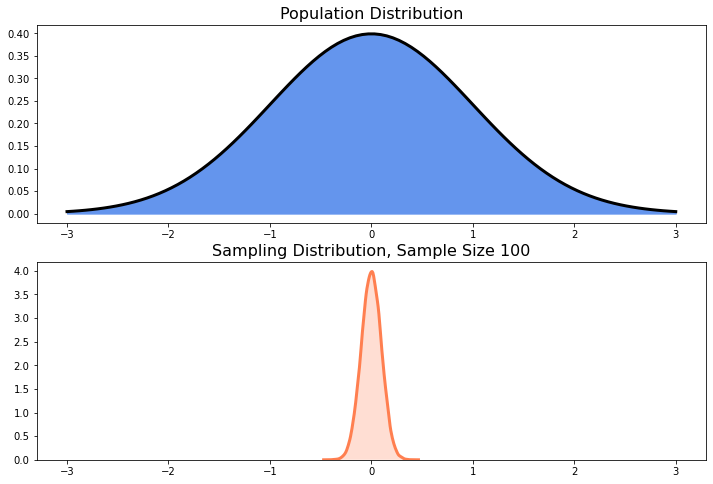

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8))
fontsize = 16

ax[0].plot(x_grid, y_grid, color = 'black', linewidth = 3)
ax[0].fill_between(x_grid, y_grid, color = 'cornflowerblue')
xmin, xmax = ax[0].get_xlim()

ax[0].set_title('Population Distribution', fontsize = fontsize)


sns.kdeplot(y.mean(axis = 1), shade = True, color = 'coral', linewidth = 3)
plt.xlim(xmin, xmax)
ax[1].set_title('Sampling Distribution, Sample Size 100', fontsize = fontsize);

Now, what happens when are observations are correlated. For example, when aggregating decision trees, the predictions arising from the individual decision trees are going to be correlated.

I will make the claim that if our samples of size $n$ have pairwise correlation $r$, the the sampling distribution of the mean will have variance equal to $r\sigma^2 + \frac{1 - r}{n}\sigma^2$.

Let's see an example of this where our observations have pairwise correlation of 0.5.

In [52]:
r = 0.5

sigma = np.full(shape = (sample_size, sample_size), fill_value = r) + (1-r)*np.identity(n = sample_size)

# Generate the random samples.
y = np.random.multivariate_normal(mu, sigma, num_samples)

First, let's look at the average sample mean. 

In [53]:
y.mean(axis = 1).mean()

-0.004311092645967463

If the claim above is true, we should expect a variance in the sample means of 0.5 + 0.5/100 = 0.505

In [54]:
y.mean(axis = 1).var()

0.5055478233913226

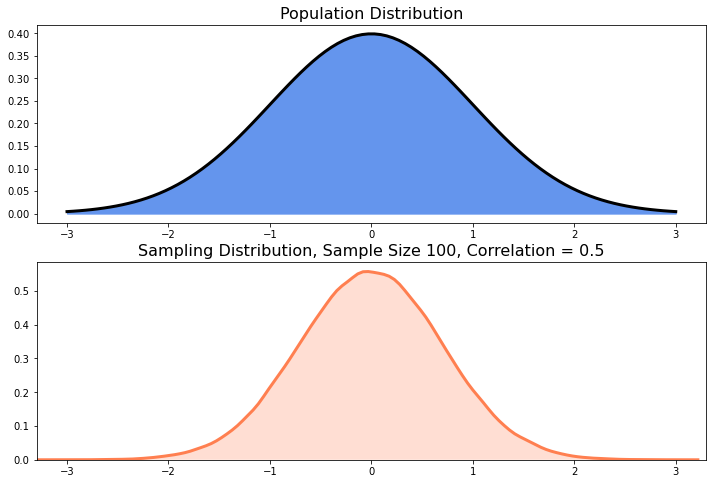

In [55]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8))
fontsize = 16

ax[0].plot(x_grid, y_grid, color = 'black', linewidth = 3)
ax[0].fill_between(x_grid, y_grid, color = 'cornflowerblue')
xmin, xmax = ax[0].get_xlim()

ax[0].set_title('Population Distribution', fontsize = fontsize)


sns.kdeplot(y.mean(axis = 1), shade = True, color = 'coral', linewidth = 3)
plt.xlim(xmin, xmax)
ax[1].set_title('Sampling Distribution, Sample Size 100, Correlation = 0.5', fontsize = fontsize);

Now, remember the **bias-variance tradeoff:** we can often get a better predictor by lowering the variance of our models.

Based on the above, one way to reduce the variance of our bootstrap aggregate models is to decrease the correlation between predictions.

This is the idea of a **random forest** model. It trains a collection of decision tree models, similar to the bootstrap models we just saw. However, to decorrelate the individual predictors, at each split, only a random subset of the predictors can be used.

Let's see these in action, using the RandomForestRegressor class from the scikit-learn ensemble module.

In [57]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [58]:
kc = pd.read_csv('../data/kc_house_data.csv')

X = kc[['date', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
y = kc['price']

X['date'] = pd.to_datetime(X['date'])
X['sales_year'] = X['date'].dt.year
X['sales_month'] = X['date'].dt.month

X['age_at_sale'] = X['sales_year'] - X['yr_built']
X['years_since_renovation'] = X['sales_year'] - np.max(X[['yr_built', 'yr_renovated']], axis = 1)

X = X.drop(columns = ['date', 'yr_built', 'yr_renovated'])

X = pd.get_dummies(X, columns = ['zipcode', 'sales_year', 'sales_month'], drop_first = True)

<ipython-input-58-ec3a98b8ae1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['date'] = pd.to_datetime(X['date'])
<ipython-input-58-ec3a98b8ae1c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sales_year'] = X['date'].dt.year


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [71]:
rf = RandomForestRegressor(n_jobs = -1, random_state=321).fit(X_train, y_train)

In [72]:
y_pred = rf.predict(X_test)

In [73]:
mean_squared_error(y_test, y_pred)

16227002380.83321

In [74]:
mean_absolute_error(y_test, y_pred)

66648.02650841969

We get a similar result to our bagged trees.

Note that random forests have a large number of hyperparameters that can be tuned to try and improve performance. We'll discuss **hyperparameter tuning** later.

One plus of using random forests is that they have a built-in method of assigning feature importance. Basically, it measures on average how much the performance improved by using a particular feature.

In [75]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})

In [76]:
feature_importances.sort_values('importance', ascending = False).head(20)

,feature,importance
8,grade,0.304276
2,sqft_living,0.267411
11,lat,0.163433
12,long,0.073123
5,waterfront,0.032348
13,sqft_living15,0.029450
9,sqft_above,0.020549
15,age_at_sale,0.017519
6,view,0.014446
3,sqft_lot,0.012661


Interestingly, zipcode 98039 comes out as one of the higher-importance features. This is the zipcode of Medina, Washington, home of Bill Gates!